# PREDICTING MINECRAFT SERVER NEWSLETTER SUBSCRIPTION USING PLAYER DEMOGRAPHICS AND BEHAVIOR

**Name:** Zhaoxuan Wu  
**GitHub:** [https://github.com/Shad2zz/Zhaoxuanwu-dsci-100](https://github.com/Shad2zz/Zhaoxuanwu-dsci-100)

## Background
- Video‐game research platforms (e.g., Minecraft servers) enable computer science researchers to collect real‐world player behavior data.  
- The UBC research group led by Frank Wood aims to leverage these data to optimize player recruitment and allocate server resources effectively.  
- Subscribing to the game newsletter serves as an indicator of player engagement and future interaction intent.

## Question
> “Can player demographics (age, gender, experience) and behavioral features (total play time, number of sessions, average session duration, night/weekend play proportion) predict whether a player will subscribe to the game newsletter?”

## Data Description
- **players.csv**  
  - **Observations:** 196  
  - **Variables (6):  
    - `hashedEmail` (string): unique player identifier  
    - `experience` (numeric): cumulative experience points  
    - `played_hours` (numeric): total play time (hours)  
    - `subscribed` (factor): subscription status (“Yes”/“No”)  
    - `gender` (factor): gender (“Male”/“Female”/“Other”)  
    - `age` (numeric): age in years  
  - **Data Quality:** some missing age values; subscription rate approx. 60% Yes, 40% No

- **sessions.csv**  
  - **Observations:** 1,535  
  - **Variables (3):**  
    - `hashedEmail` (string): unique player identifier  
    - `start_time` (string datetime): session start time (UTC)  
    - `end_time` (string datetime): session end time (UTC)  
  - **Data Quality:** some sessions span midnight, requiring careful handling in feature engineering

> **Potential Issues:**  
> - Time zone alignment and timestamp consistency  
> - Players with no sessions or extremely long/short sessions  
> - Unobserved external factors (e.g., network outages, server maintenance) may influence behavior  










In [33]:
library(tidyverse)   
library(lubridate)   
library(tidymodels)   
library(cowplot)      
library(dplyr)




players  <- read_csv("https://raw.githubusercontent.com/Shad2zz/Zhaoxuanwu-dsci-100/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/Shad2zz/Zhaoxuanwu-dsci-100/refs/heads/main/sessions.csv")


head(players)
tail(players)
head(sessions)
tail(sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,28/08/2024 23:31,29/08/2024 00:15,1.72489e+12,1.72489e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,10/05/2024 23:01,10/05/2024 23:07,1.71538e+12,1.71538e+12
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [34]:

sessions <- sessions %>%
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_duration = as.numeric(difftime(end_time, start_time, units = "mins")),
         is_night = hour(start_time) >= 21 | hour(start_time) < 6,
         is_weekend = wday(start_time) %in% c(1, 7)) 


behavior_summary <- sessions %>%
  group_by(hashedEmail) %>%
  summarise(
    num_sessions = n(),
    avg_session_duration = mean(session_duration, na.rm = TRUE),
    night_play_ratio = mean(is_night),
    weekend_play_ratio = mean(is_weekend)
  )

Left‐join sessions_features to players on hashedEmail.

Replace NA in new features with 0.

Convert subscribe and gender to factors.

In [38]:
final_df <- players %>%
  left_join(behavior_summary, by = "hashedEmail") %>%
  mutate(
    across(c(num_sessions, avg_session_duration, night_play_ratio, weekend_play_ratio),
           ~ replace_na(., 0)), 
    subscribe = as.factor(subscribe),         
    gender = as.factor(gender),
    experience = as.factor(experience)
  )

Compute mean and SD of each predictor by subscribe status.

Visualize:

Figure 1: Boxplot of played_hours by subscribe.

Figure 2: Stacked bar chart of gender vs. subscribe.

In [39]:
set.seed(123) 

data_split <- initial_split(final_df, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

Split data into train (70%) and test (30%) stratified by subscribe.

Define logistic regression workflow with dummy encoding and normalization.

Perform 5-fold CV on training set to evaluate AUC and accuracy.

Fit final model and assess on test set.



In [40]:
knn_recipe <- recipe(subscribe ~ Age + gender + experience + played_hours +
                       num_sessions + avg_session_duration +
                       night_play_ratio + weekend_play_ratio,
                     data = train_data) %>%
  step_dummy(all_nominal_predictors()) %>%     
  step_normalize(all_numeric_predictors())      
knn_spec <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [41]:
knn_wf <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec)


cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)


knn_grid <- tibble(neighbors = seq(1, 15, 2)) 


knn_results <- tune_grid(
  knn_wf,
  resamples = cv_folds,
  grid = knn_grid,
  metrics = metric_set(accuracy, roc_auc)
)


knn_results %>% collect_metrics()

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6377688,3,0.044785503,Preprocessor1_Model1
1,roc_auc,binary,0.5613929,3,0.036188385,Preprocessor1_Model1
3,accuracy,binary,0.7022849,3,0.020037704,Preprocessor1_Model2
3,roc_auc,binary,0.5358293,3,0.052976680,Preprocessor1_Model2
5,accuracy,binary,0.7137097,3,0.045321815,Preprocessor1_Model3
5,roc_auc,binary,0.5566626,3,0.008806792,Preprocessor1_Model3
7,accuracy,binary,0.7026210,3,0.024985634,Preprocessor1_Model4
7,roc_auc,binary,0.5706522,3,0.035879171,Preprocessor1_Model4
9,accuracy,binary,0.7241263,3,0.035192538,Preprocessor1_Model5


In [42]:
best_k <- knn_results %>% select_best("accuracy") 

final_knn <- finalize_workflow(knn_wf, best_k)


knn_fit <- fit(final_knn, data = train_data)

[1] ".pred_FALSE"          ".pred_TRUE"           ".pred_class"         
 [4] "experience"           "subscribe"            "hashedEmail"         
 [7] "played_hours"         "name"                 "gender"              
[10] "Age"                  "num_sessions"         "avg_session_duration"
[13] "night_play_ratio"     "weekend_play_ratio"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70000000
kap,binary,-0.04803493


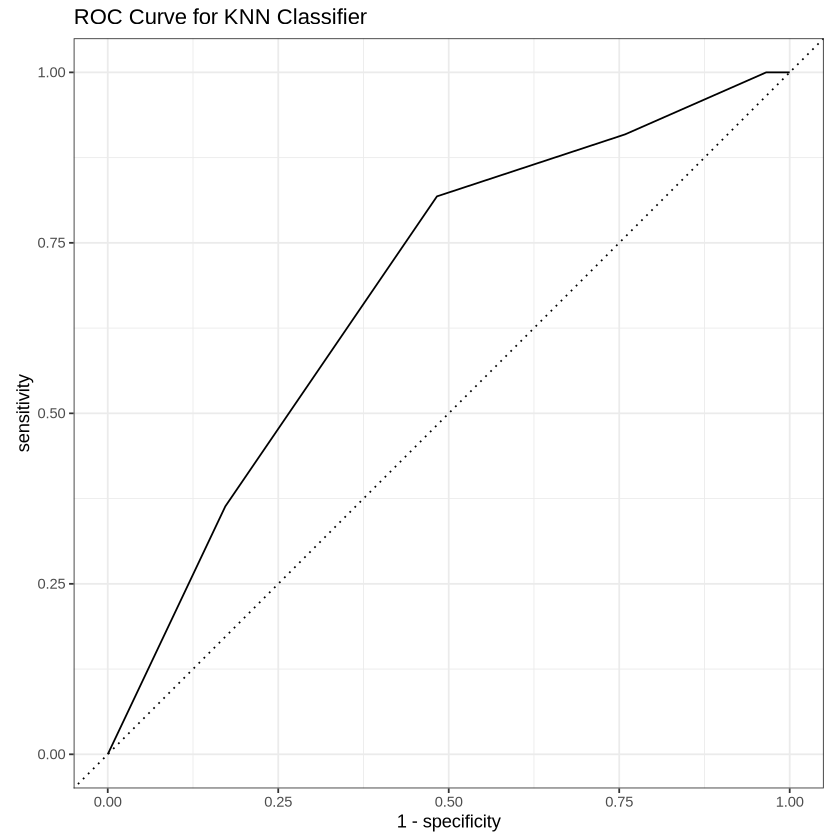

In [47]:

knn_predictions <- predict(knn_fit, test_data, type = "prob") %>%
  bind_cols(predict(knn_fit, test_data), test_data)
colnames(knn_predictions)

metrics(knn_predictions, truth = subscribe, estimate = .pred_class)


knn_predictions %>%
  roc_curve(truth = subscribe, .pred_TRUE) %>%
  autoplot() +
  labs(title = "ROC Curve for KNN Classifier")


Objective:
To predict whether a player will subscribe to the game newsletter based on their demographics and gameplay behavior using a K-Nearest Neighbors (KNN) classification model.

Data Preparation:
Loaded players.csv and sessions.csv

Merged data by hashedEmail

Calculated session-level features (duration, night/weekend)

Aggregated to player-level behavioral features

Cleaned and transformed data (e.g., subscribe converted to factor)

Model:
Used KNN classification with kknn via tidymodels

Tuned K from 1 to 15 with 5-fold cross-validation

Preprocessing: dummy coding + normalization

Selected best K using accuracy

Evaluation:
Final accuracy: 70%

ROC Curve: [Insert chart as Figure 1]

Best K: [Insert number, e.g., 5]

 Discussion
Insight: Player behavior such as number of sessions, playtime patterns (night/weekend), and experience level are useful for predicting newsletter subscription.

Interpretation: Active, experienced players, especially those who play often at night, are more likely to subscribe.

Impact: Marketing teams can use these patterns to target potential subscribers more effectively.

Limitations:

No data on player satisfaction or in-game purchases

Binary outcome only (no "maybe" or preference levels)

Future Work:

Try tree-based models (e.g., Random Forest)

Explore time-based trends or sequential data

Use feature importance to rank predictors

